In [1]:
import numpy as np
from xgboost import XGBRanker
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import psycopg2
from gensim.models.doc2vec import Doc2Vec
from gensim.utils import simple_preprocess
import tensorflow as tf
import tensorflow.keras.backend as K
from faiss import read_index
from psycopg2.extras import execute_values
import pickle
import pandas as pd
from operator import itemgetter

2024-01-10 11:08:24.423233: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Create dataset

In [288]:
connection = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="127.0.0.1",
    port="54320",
    database="stack_overflow",
)
question_embeddings_model = Doc2Vec.load("python.doc")
question_transformer_model = tf.keras.models.load_model(
    "../../scripts/text_model/question_transformer_model"
)
index = read_index("../../scripts/text_model/users_imp.index")

In [289]:
with open("../../scripts/text_model/user_embeddings.pickle", "rb") as f:
    user_embedding, user_encoder = pickle.load(f)

In [290]:
MIN_ANSWERS = 4
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            f"""select p.id, p.title, p.body_text
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join posts_19 a on a.parent_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.creation_date < '2022-01-01'
        and t.tag_name = 'python'
        group by p.id
        HAVING count(*) > {MIN_ANSWERS}
        limit 30000"""
        )
        posts = cursor.fetchall()

In [291]:
posts_vectors = []
posts_ids = []
for p_id, title, body in posts:
    posts_ids.append(p_id)
    post_text = body
    if title is not None:
        post_text = title + "\n\n" + body
    posts_vectors.append(
        question_embeddings_model.infer_vector(simple_preprocess(post_text))
    )

In [266]:
posts_vectors = np.array(posts_vectors)
posts_vectors.shape

(13205, 50)

In [267]:
questions_transformed = question_transformer_model.predict(posts_vectors)
questions_transformed.shape

413/413 [==============================] - 0s 698us/step


(13205, 10)

In [268]:
qid2emb = {pid: emb for pid, emb in zip(posts_ids, questions_transformed)}

In [269]:
distances, similar_questions = index.search(questions_transformed, 10000)
features_df = pd.DataFrame(
    list(zip(posts_ids, similar_questions)), columns=["q_id", "u_id"]
).explode("u_id")
features_df["u_id"] = features_df["u_id"].astype(int)

In [270]:
features_df

,q_id,u_id
0,773,12234734
0,773,3558077
0,773,7122438
0,773,3286487
0,773,14978092
...,...,...
13204,70545736,7145465
13204,70545736,11592386
13204,70545736,11369701
13204,70545736,10791931


In [271]:
batch_size = 1000000

results = []
with connection:
    for batch_idx in range(len(features_df) // batch_size):
        with connection.cursor() as cursor:
            execute_values(
                cursor,
                """select q_id, u_id, q_a.score
                                    FROM (VALUES %s) AS base_questions (q_id, u_id)
                                    JOIN posts_19 q_a ON q_a.parent_id = q_id
                                    WHERE q_a.owner_user_id=u_id""",
                features_df[batch_idx * batch_size : (batch_idx + 1) * batch_size][
                    ["q_id", "u_id"]
                ].values.tolist(),
                page_size=batch_size,
            )
            results.extend(cursor.fetchall())
dataset = pd.DataFrame(results, columns=["q_id", "u_id", "score"])

In [272]:
dataset.sort_values(by=["q_id"], inplace=True)
print(len(dataset))
dataset.head()

30525


,q_id,u_id,score
138,773,4531270,145
104,773,650654,33
20,972,15096247,1
256,972,541136,157
102,1854,3191896,14


In [281]:
feats = np.concatenate(
    (
        user_embedding[user_encoder.transform(dataset["u_id"])],
        np.array(itemgetter(*dataset["q_id"])(qid2emb)),
    ),
    axis=1,
)
scores = dataset["score"]
q_ids = dataset["q_id"]

train_feats = feats[:25000]
train_scores = scores[:25000]
train_q_ids = q_ids[:25000]

eval_feats = feats[25000:]
eval_scores = scores[25000:]
eval_q_ids = q_ids[25000:]

# Train LTR

In [349]:
params = {
    "objective": "rank:pairwise",
    "learning_rate": 0.1,
    "gamma": 1.0,
    "min_child_weight": 0.1,
    "max_depth": 6,
    "n_estimators": 200,
    "early_stopping_rounds": 50,
    "objective": "rank:ndcg",
    "eval_metric": ["ndcg"],
}
# 'eval_metric':["map", "ndcg"],}
ranker = XGBRanker(**params)

In [350]:
ranker.fit(
    feats,
    scores,
    qid=q_ids,
    eval_set=[(eval_feats, eval_scores)],
    eval_qid=[eval_q_ids],
)
# eval_metric=ndcg_score)

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None,
          early_stopping_rounds=50, enable_categorical=False,
          eval_metric=['ndcg'], feature_types=None, gamma=1.0, gpu_id=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.1, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
          max_leaves=None, min_child_weight=0.1, missing=nan,
          monotone_constraints=None, n_estimators=200, n_jobs=None,
          num_parallel_tree=None, objective='rank:ndcg', predictor=None, ...)

In [351]:
ranker.get_num_boosting_rounds(), ranker.best_score, ranker.best_iteration

(200, 0.9039975513944346, 196)

In [352]:
# plt.plot(ranker.evals_result()["validation_0"]["map"])
# plt.xlabel("Round")
# plt.ylabel("MAP")
# plt.show()

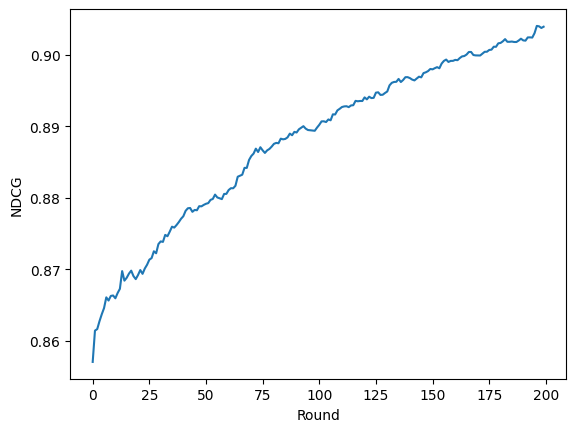

In [353]:
plt.plot(ranker.evals_result()["validation_0"]["ndcg"])
plt.xlabel("Round")
plt.ylabel("NDCG")
xgboostrank_loss.pdf
plt.show()

In [371]:
eval_X = pd.DataFrame(list(zip(eval_feats.tolist(), eval_q_ids)), columns=["X", "qid"])
eval_X.head()

,X,qid
0,"[0.36553826928138733, -0.1780138462781906, 0.3...",65155606
1,"[0.3693523705005646, -0.17812000215053558, 0.3...",65155606
2,"[0.3667551577091217, -0.17811796069145203, 0.3...",65155606
3,"[0.37019971013069153, -0.1782977432012558, 0.3...",65155763
4,"[0.3693523705005646, -0.17812000215053558, 0.3...",65155763


In [374]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

predicted_scores = ranker.predict(eval_feats)

grouped_predicted_scores = []
grouped_eval_scores = []

last_qid = eval_q_ids.values[0]
last_predicted_scores = []
last_eval_scores = []
for pscore, escore, q_id in zip(predicted_scores, eval_scores, eval_q_ids):
    if q_id == last_qid:
        last_predicted_scores.append(pscore)
        last_eval_scores.append(escore)
    else:
        grouped_predicted_scores.append(last_predicted_scores)
        grouped_eval_scores.append(last_eval_scores)
        last_predicted_scores = [pscore]
        last_eval_scores = [escore]
        last_qid = q_id

grouped_predicted_scores.append(last_predicted_scores)
grouped_eval_scores.append(last_eval_scores)

In [377]:
group_ncdg = []

for p_scores, e_scores in zip(grouped_predicted_scores, grouped_eval_scores):
    if len(p_scores) > 1:
        group_ncdg.append(ndcg_score([p_scores], [e_scores]))

group_ncdg = np.array(group_ncdg)
group_ncdg.mean(), group_ncdg.std()

(0.8202570246321309, 3.606297562263516)

In [373]:
ranker.save_model("xgboost_ranker")